In [4]:
## Import the pandas library to work with dataframes
import pandas as pd
import requests
from bs4 import BeautifulSoup, Comment

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
# Set up out variables

year = 2022
url = "https://www.hockey-reference.com/leagues/NHL_2022_skaters.html"

# Read in the dataframe from hockey-reference
df = pd.read_html(url,header=1)[0]

#Add a column that indicates the year. This will be most useful if/when we start reading in
#additional years of data.
df['year'] = year

# Reading in the table adds a row every 50 players or so that is just a copy of the column headers. 
# Remove that by choosing an input that wouldn't ever show up for a player in that column.
df = df[~df['Age'].str.contains("Age")]

# check the data types
df.dtypes

# Reading in the dataframe from a website makes everything an object. Let's put in the work to change all of these to their 
# Proper data type

Rk        object
Player    object
Age       object
Tm        object
Pos       object
GP        object
G         object
A         object
PTS       object
+/-       object
PIM       object
PS        object
EV        object
PP        object
SH        object
GW        object
EV.1      object
PP.1      object
SH.1      object
S         object
S%        object
TOI       object
ATOI      object
BLK       object
HIT       object
FOW       object
FOL       object
FO%       object
year       int64
dtype: object

In [6]:
# Fill in the blank cells with zero. These are cells such as faceoff percentage being blank when that player didn't 
# take a faceoff during the season. Let's just make these '0'
df = df.fillna(0)

# Changing the data types one at a time. There must be a better way to do this...
df = df.astype({"Age": int, "GP": int, "G": int, "A": int, "PTS": int, "+/-": int, "PIM": int, "PS": float, "EV": int, "PP": int, "SH": int, "GW": int, "EV.1": int, "PP.1": int, "SH.1": int, "S": int, "S%": float, "TOI": float, "BLK": int, "HIT": int, "FOW": int, "FOL": int, "FO%": float})

# Average time on ice column throws an error when trying to turn it into a float, so let's just recalculate now. We 
# have to do this later anyway, so let's just avoid the problme and do this now.
df['ATOI'] = round(df['TOI']/df['GP'], 2)

# Drop the 'Rk' axis, it's redundant. Also, there are rows that total the points when players play for more than one
# team during the season. Let's not double count.
df = df.drop('Rk', axis = 1)
df = df[df['Tm'] != 'TOT']

# Let's check to see if we've done everything properly.
df.head(10)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,...,8,12.5,92.0,10.22,3,7,2,5,28.6,2022
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,...,32,9.4,240.0,12.00,16,48,84,82,50.6,2022
2,Calen Addison,21,MIN,D,15,2,2,4,-4,2,...,17,11.8,207.0,13.80,6,12,0,0,0.0,2022
3,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,...,1,0.0,7.0,7.00,0,4,1,2,33.3,2022
4,Jack Ahcan,24,BOS,D,6,1,0,1,-3,0,...,5,20.0,96.0,16.00,5,8,0,0,0.0,2022
5,Sebastian Aho,24,CAR,F,79,37,44,81,18,38,...,221,16.7,1497.0,18.95,23,76,555,504,52.4,2022
6,Sebastian Aho,25,NYI,D,36,2,10,12,-6,10,...,34,5.9,592.0,16.44,42,32,0,0,0.0,2022
7,Alexander Alexeyev,22,WSH,D,1,0,0,0,0,2,...,0,0.0,11.0,11.00,0,1,0,0,0.0,2022
8,Wade Allison,24,PHI,RW,1,0,0,0,-1,0,...,2,0.0,8.0,8.00,0,1,0,0,0.0,2022
10,Michael Amadio,25,VEG,C,53,11,7,18,0,15,...,62,17.7,653.0,12.32,16,39,30,40,42.9,2022


In [7]:
# I want t break up the dataset, now that it's clean with everything I want, into Forwards and defensemen. 
# This is looking towards the future, as I want to eventually break these players up into player types, 
# and forwards and defensemen will naturally have different types to cluster into.
def_df = df[df['Pos']== 'D'].reset_index()
forward_df = df[df['Pos'] != 'D'].reset_index()

forward_df = forward_df.drop('index', axis=1)
def_df = def_df.drop('index', axis=1)
# We did that correctly, right?
forward_df.head(10)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,...,8,12.5,92.0,10.22,3,7,2,5,28.6,2022
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,...,32,9.4,240.0,12.00,16,48,84,82,50.6,2022
2,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,...,1,0.0,7.0,7.00,0,4,1,2,33.3,2022
3,Sebastian Aho,24,CAR,F,79,37,44,81,18,38,...,221,16.7,1497.0,18.95,23,76,555,504,52.4,2022
4,Wade Allison,24,PHI,RW,1,0,0,0,-1,0,...,2,0.0,8.0,8.00,0,1,0,0,0.0,2022
5,Michael Amadio,25,VEG,C,53,11,7,18,0,15,...,62,17.7,653.0,12.32,16,39,30,40,42.9,2022
6,Michael Amadio,25,TOR,C,3,0,0,0,1,0,...,2,0.0,27.0,9.00,0,3,0,2,0.0,2022
7,Joey Anderson,23,TOR,RW,5,0,0,0,0,0,...,10,0.0,44.0,8.80,0,3,0,0,0.0,2022
8,Josh Anderson,27,MTL,RW,69,19,13,32,-25,65,...,151,12.6,1189.0,17.23,35,153,20,22,47.6,2022
9,Jaret Anderson-Dolan,22,LAK,C,7,0,0,0,-3,4,...,5,0.0,97.0,13.86,3,12,9,7,56.3,2022


In [8]:
# Let's sort by most points, instead of alphabetically. The most impactful players should find themselves near the top, right?
df = df.sort_values('PTS', ascending = False)
df.head(10)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
741,Connor McDavid,25,EDM,C,80,44,79,123,28,45,...,314,14.0,1765.0,22.06,26,75,562,484,53.7,2022
378,Johnny Gaudreau,28,CGY,LW,82,40,75,115,64,26,...,262,15.3,1523.0,18.57,9,10,1,0,100.0,2022
490,Jonathan Huberdeau,28,FLA,LW,80,30,85,115,35,54,...,222,13.5,1554.0,19.42,28,99,18,36,33.3,2022
284,Leon Draisaitl,26,EDM,C,80,55,55,110,17,40,...,278,19.8,1788.0,22.35,25,53,887,774,53.4,2022
555,Kirill Kaprizov,24,MIN,LW,81,47,61,108,27,34,...,289,16.3,1548.0,19.11,29,73,5,4,55.6,2022
727,Auston Matthews,24,TOR,C,73,60,46,106,20,18,...,348,17.2,1504.0,20.60,62,67,691,538,56.2,2022
1057,Steven Stamkos,31,TBL,C,81,42,64,106,24,36,...,241,17.4,1497.0,18.48,31,93,545,523,51.0,2022
1125,Matthew Tkachuk,24,CGY,LW,82,42,62,104,57,68,...,253,16.6,1468.0,17.90,20,93,20,23,46.5,2022
771,J.T. Miller,28,VAN,C,80,32,67,99,15,47,...,206,15.5,1686.0,21.08,56,172,667,566,54.1,2022
719,Mitch Marner,24,TOR,RW,72,35,62,97,23,16,...,224,15.6,1504.0,20.89,31,75,10,8,55.6,2022


In [ ]:
# Now that the dataframe is how I want it, let's save it to a CSV so I can transfer it into Power BI.
df.to_csv("Desktop/NHL csv/NHL_Players.csv", index = False)

In [ ]:
def_df.to_csv("Desktop/NHL csv/NHL_Defenders.csv", index = False)
forward_df.to_csv("Desktop/NHL csv/NHL_Forwards.csv", index = False)

In [9]:
# Okay, this is complex. If you follow the url, we want the table titled "Team Statistics". But if we 
# do the standard read_html() like before, we only scrape until the table JUST before this one. 
# This is because the table we want, and all the other tables further down, are in the html comments
# for some reason. SO we have to do a bunch of extra work to get it out. But once we do, we can 
# work with it the same way as any other dataframe. Code modified from:
# https://stackoverflow.com/questions/65190821/python-pandas-read-html-function-missing-some-tables-from-pro-football-reference

response = requests.get('https://www.hockey-reference.com/leagues/NHL_2022.html')

soup = BeautifulSoup(response.text, 'html.parser')
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

tables = []
for each in comments:
    if 'table' in each:
        try:
            tables.append(pd.read_html(each, header=1)[0])
        except:
            continue
# The table ends up being pulled in as the first table in the list. That's convinient!

df_2 = tables[0]

# and checking to make sure the table came in correctly.

df_2.head(10)

,Rk,Unnamed: 1,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1.0,Florida Panthers*,27.8,82,58,18,6,122,0.744,337,...,79.54,12,8,10.1,10.8,3062,11.0,2515,0.904,5
1,2.0,Colorado Avalanche*,28.2,82,56,19,7,119,0.726,308,...,79.66,6,5,9.0,10.4,2874,10.7,2625,0.912,7
2,3.0,Carolina Hurricanes*,28.3,82,54,20,8,116,0.707,277,...,88.04,4,3,9.2,7.7,2798,9.9,2310,0.913,6
3,4.0,Toronto Maple Leafs*,28.4,82,54,21,7,115,0.701,312,...,82.05,13,4,8.6,8.5,2835,11.0,2511,0.900,7
4,5.0,Minnesota Wild*,29.4,82,53,22,7,113,0.689,305,...,76.14,2,5,10.8,10.8,2666,11.4,2577,0.903,3
5,6.0,Calgary Flames*,28.8,82,50,21,11,111,0.677,291,...,83.20,7,3,9.1,8.6,2908,10.0,2374,0.913,11
6,7.0,Tampa Bay Lightning*,29.6,82,51,23,8,110,0.671,285,...,80.56,7,5,11.0,11.4,2535,11.2,2441,0.907,3
7,8.0,New York Rangers*,26.7,82,52,24,6,110,0.671,250,...,82.30,8,2,8.2,8.2,2392,10.5,2528,0.919,9
8,9.0,St. Louis Blues*,28.8,82,49,22,11,109,0.665,309,...,84.09,9,5,7.5,7.9,2492,12.4,2591,0.908,4
9,10.0,Boston Bruins*,28.5,82,51,26,5,107,0.652,253,...,81.30,5,6,9.9,9.4,2962,8.5,2354,0.907,4


In [10]:
df_2.dtypes

# Oh this is awesome, this code pulled in the datatypes properly already,we don't have to go through each column
# and change them one at a time to the proper type.
# Now, we clean. The bottom row (don't need a total), name
# the teams column, and remove the * character from the teams that have it, and add a year column.
# I already know exactly what this table looks like, there aren't any null values in here, so I don't need
# to worry about filling them in.

Rk            float64
Unnamed: 1     object
AvAge         float64
GP              int64
W               int64
L               int64
OL              int64
PTS             int64
PTS%          float64
GF              int64
GA              int64
SOW           float64
SOL           float64
SRS           float64
SOS           float64
GF/G          float64
GA/G          float64
PP              int64
PPO             int64
PP%           float64
PPA             int64
PPOA            int64
PK%           float64
SH              int64
SHA             int64
PIM/G         float64
oPIM/G        float64
S               int64
S%            float64
SA              int64
SV%           float64
SO              int64
dtype: object

In [11]:
df_2.rename(columns={'Unnamed: 1': 'TeamName'}, inplace=True)
df_2 = df_2.drop(df_2[df_2['TeamName']=='League Average'].index)
df_2['TeamName'] = df_2['TeamName'].str.strip('*')
df_2['Year'] = year

# and to check all that is done properly...
df_2.head(10)

,Rk,TeamName,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO,Year
0,1.0,Florida Panthers,27.8,82,58,18,6,122,0.744,337,...,12,8,10.1,10.8,3062,11.0,2515,0.904,5,2022
1,2.0,Colorado Avalanche,28.2,82,56,19,7,119,0.726,308,...,6,5,9.0,10.4,2874,10.7,2625,0.912,7,2022
2,3.0,Carolina Hurricanes,28.3,82,54,20,8,116,0.707,277,...,4,3,9.2,7.7,2798,9.9,2310,0.913,6,2022
3,4.0,Toronto Maple Leafs,28.4,82,54,21,7,115,0.701,312,...,13,4,8.6,8.5,2835,11.0,2511,0.900,7,2022
4,5.0,Minnesota Wild,29.4,82,53,22,7,113,0.689,305,...,2,5,10.8,10.8,2666,11.4,2577,0.903,3,2022
5,6.0,Calgary Flames,28.8,82,50,21,11,111,0.677,291,...,7,3,9.1,8.6,2908,10.0,2374,0.913,11,2022
6,7.0,Tampa Bay Lightning,29.6,82,51,23,8,110,0.671,285,...,7,5,11.0,11.4,2535,11.2,2441,0.907,3,2022
7,8.0,New York Rangers,26.7,82,52,24,6,110,0.671,250,...,8,2,8.2,8.2,2392,10.5,2528,0.919,9,2022
8,9.0,St. Louis Blues,28.8,82,49,22,11,109,0.665,309,...,9,5,7.5,7.9,2492,12.4,2591,0.908,4,2022
9,10.0,Boston Bruins,28.5,82,51,26,5,107,0.652,253,...,5,6,9.9,9.4,2962,8.5,2354,0.907,4,2022


In [12]:
# Now I want to add a "TeamCode" column so that this table can connect to the previous table through it.

df_2['TeamCode']= df_2['TeamName']

df_2.head(10)

,Rk,TeamName,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO,Year,TeamCode
0,1.0,Florida Panthers,27.8,82,58,18,6,122,0.744,337,...,8,10.1,10.8,3062,11.0,2515,0.904,5,2022,Florida Panthers
1,2.0,Colorado Avalanche,28.2,82,56,19,7,119,0.726,308,...,5,9.0,10.4,2874,10.7,2625,0.912,7,2022,Colorado Avalanche
2,3.0,Carolina Hurricanes,28.3,82,54,20,8,116,0.707,277,...,3,9.2,7.7,2798,9.9,2310,0.913,6,2022,Carolina Hurricanes
3,4.0,Toronto Maple Leafs,28.4,82,54,21,7,115,0.701,312,...,4,8.6,8.5,2835,11.0,2511,0.900,7,2022,Toronto Maple Leafs
4,5.0,Minnesota Wild,29.4,82,53,22,7,113,0.689,305,...,5,10.8,10.8,2666,11.4,2577,0.903,3,2022,Minnesota Wild
5,6.0,Calgary Flames,28.8,82,50,21,11,111,0.677,291,...,3,9.1,8.6,2908,10.0,2374,0.913,11,2022,Calgary Flames
6,7.0,Tampa Bay Lightning,29.6,82,51,23,8,110,0.671,285,...,5,11.0,11.4,2535,11.2,2441,0.907,3,2022,Tampa Bay Lightning
7,8.0,New York Rangers,26.7,82,52,24,6,110,0.671,250,...,2,8.2,8.2,2392,10.5,2528,0.919,9,2022,New York Rangers
8,9.0,St. Louis Blues,28.8,82,49,22,11,109,0.665,309,...,5,7.5,7.9,2492,12.4,2591,0.908,4,2022,St. Louis Blues
9,10.0,Boston Bruins,28.5,82,51,26,5,107,0.652,253,...,6,9.9,9.4,2962,8.5,2354,0.907,4,2022,Boston Bruins


In [13]:
# And now to begin the arduous task of changing the team names into their 3 character codes one by one...

df_2['TeamCode'] = df_2['TeamCode'].replace(['Florida Panthers','Colorado Avalanche','Carolina Hurricanes', 'Toronto Maple Leafs','Minnesota Wild','Calgary Flames','Tampa Bay Lightning','New York Rangers','St. Louis Blues','Boston Bruins','Edmonton Oilers','Pittsburgh Penguins','Washington Capitals','Los Angeles Kings','Dallas Stars','Nashville Predators','Vegas Golden Knights','Vancouver Canucks','Winnipeg Jets','New York Islanders','Columbus Blue Jackets', 'San Jose Sharks','Anaheim Ducks','Buffalo Sabres','Detroit Red Wings','Ottawa Senators','Chicago Blackhawks','New Jersey Devils','Philadelphia Flyers','Seattle Kraken','Arizona Coyotes','Montreal Canadiens'],['FLA','COL', 'CAR', 'TOR','MIN', 'CGY','TBL','NYR','STL','BOS','EDM', 'PIT','WSH','LAK','DAL','NSH','VEG','VAN','WPG','NYI','CBJ','SJS','ANA','BUF','DET','OTT','CHI','NJD','PHI','SEA','ARI','MTL'])

df_2.head(10)

,Rk,TeamName,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO,Year,TeamCode
0,1.0,Florida Panthers,27.8,82,58,18,6,122,0.744,337,...,8,10.1,10.8,3062,11.0,2515,0.904,5,2022,FLA
1,2.0,Colorado Avalanche,28.2,82,56,19,7,119,0.726,308,...,5,9.0,10.4,2874,10.7,2625,0.912,7,2022,COL
2,3.0,Carolina Hurricanes,28.3,82,54,20,8,116,0.707,277,...,3,9.2,7.7,2798,9.9,2310,0.913,6,2022,CAR
3,4.0,Toronto Maple Leafs,28.4,82,54,21,7,115,0.701,312,...,4,8.6,8.5,2835,11.0,2511,0.900,7,2022,TOR
4,5.0,Minnesota Wild,29.4,82,53,22,7,113,0.689,305,...,5,10.8,10.8,2666,11.4,2577,0.903,3,2022,MIN
5,6.0,Calgary Flames,28.8,82,50,21,11,111,0.677,291,...,3,9.1,8.6,2908,10.0,2374,0.913,11,2022,CGY
6,7.0,Tampa Bay Lightning,29.6,82,51,23,8,110,0.671,285,...,5,11.0,11.4,2535,11.2,2441,0.907,3,2022,TBL
7,8.0,New York Rangers,26.7,82,52,24,6,110,0.671,250,...,2,8.2,8.2,2392,10.5,2528,0.919,9,2022,NYR
8,9.0,St. Louis Blues,28.8,82,49,22,11,109,0.665,309,...,5,7.5,7.9,2492,12.4,2591,0.908,4,2022,STL
9,10.0,Boston Bruins,28.5,82,51,26,5,107,0.652,253,...,6,9.9,9.4,2962,8.5,2354,0.907,4,2022,BOS


In [ ]:
# let's save this as another csv so we can import nicely into Power BI.

df_2.to_csv("Desktop/NHL csv/Team_Stats.csv", index = False)

# Now to Cluster!

There are a few ways to do this. The goal here is to naively recreate what EASports does with their NHL games. They group players into one of several different catagories depending on play style. These Groups are:

*Forwards (6):
    Sniper
    Playmaker
    Power Forward
    Two-Way
    Grinder
    Enforcer

*Defencemen (4):
    Offensive Defenceman
    Defensive Defenceman
    Two-Way Defenceman
    Enforcer

The obvious thing to do, then, would be to try and cluster our data into the same number of groups that EA does. And we WILL do that. But we will also check to see if that number of clusters is the BEST, so to speak, by implementing the elbow method on our data and clustering by the supposed ideal.

In [14]:
forward_df.head()

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,...,8,12.5,92.0,10.22,3,7,2,5,28.6,2022
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,...,32,9.4,240.0,12.00,16,48,84,82,50.6,2022
2,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,...,1,0.0,7.0,7.00,0,4,1,2,33.3,2022
3,Sebastian Aho,24,CAR,F,79,37,44,81,18,38,...,221,16.7,1497.0,18.95,23,76,555,504,52.4,2022
4,Wade Allison,24,PHI,RW,1,0,0,0,-1,0,...,2,0.0,8.0,8.00,0,1,0,0,0.0,2022


There are several columns here that won't matter whatsoever to our analysis.The name, for example, won't matter at all to what type of player you are. As won't the age and the team you play for. The year won't  matter either, unless you think two=way players like 2022 for some reason. Let's remove anything that SHOULDN'T matter.

In [15]:
ftest = forward_df.drop(['Player', 'Age', 'Tm', 'Pos', 'GP'], axis=1)
ftest.head()

,G,A,PTS,+/-,PIM,PS,EV,PP,SH,GW,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,1,0,1,-1,2,0.0,1,0,0,1,...,8,12.5,92.0,10.22,3,7,2,5,28.6,2022
1,3,5,8,2,11,0.6,3,0,0,1,...,32,9.4,240.0,12.00,16,48,84,82,50.6,2022
2,0,0,0,0,0,0.0,0,0,0,0,...,1,0.0,7.0,7.00,0,4,1,2,33.3,2022
3,37,44,81,18,38,9.5,23,13,1,9,...,221,16.7,1497.0,18.95,23,76,555,504,52.4,2022
4,0,0,0,-1,0,0.0,0,0,0,0,...,2,0.0,8.0,8.00,0,1,0,0,0.0,2022


A big problem with clustering algorithms is that they don't work nicely with a large number of variables, known as "The curse of dimentionality". We should try and reduce these columns down to something much more manageable. I am going to slightly arbitrarily choose three columns, by doing something called Principle component analysis.

<AxesSubplot:>

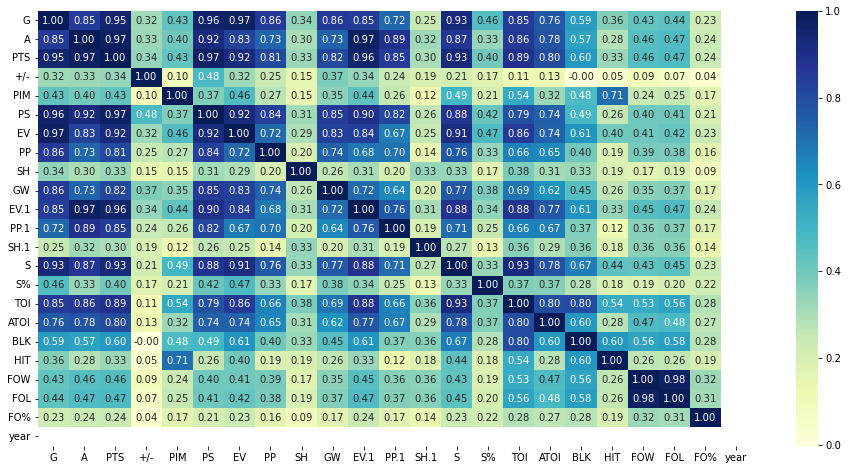

In [16]:
plt.figure(figsize= (16, 8))
sns.heatmap(ftest.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f')

There are no catagorical variables left in the data, so we don't have to get dummy variables to play nice with the clustering. We SHOULD scale the data and then reduce the dimensions.

In [17]:
ftest_scaled = ftest.copy()
scaler = StandardScaler()
scaler.fit(ftest_scaled)

ftest_scaled = pd.DataFrame(scaler.transform(ftest_scaled), columns=ftest_scaled.columns)
ftest_scaled.head()

,G,A,PTS,+/-,PIM,PS,EV,PP,SH,GW,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,-0.801693,-0.877601,-0.878076,0.007075,-0.797018,-0.713508,-0.827488,-0.557275,-0.386254,-0.206560,...,-0.984869,0.403243,-1.113011,-0.893570,-0.976988,-0.880194,-0.534985,-0.564886,-0.412601,0.0
1,-0.619304,-0.545508,-0.598742,0.268007,-0.407848,-0.504053,-0.575405,-0.557275,-0.386254,-0.206560,...,-0.670797,-0.006055,-0.824355,-0.410319,-0.206880,-0.099505,-0.105484,-0.126108,0.587687,0.0
2,-0.892887,-0.877601,-0.917981,0.094053,-0.883500,-0.713508,-0.953529,-0.557275,-0.386254,-0.680121,...,-1.076473,-1.247154,-1.278793,-1.767766,-1.154705,-0.937317,-0.540222,-0.581982,-0.198903,0.0
3,2.481309,2.044817,2.314318,1.659643,0.759659,2.602863,1.945418,3.140207,1.063215,3.581927,...,1.802516,0.957776,1.627268,1.476534,0.207794,0.433647,2.361528,2.278622,0.669528,0.0
4,-0.892887,-0.877601,-0.917981,0.007075,-0.883500,-0.713508,-0.953529,-0.557275,-0.386254,-0.680121,...,-1.063387,-1.247154,-1.276843,-1.496277,-1.154705,-0.994441,-0.545460,-0.593378,-1.712975,0.0


In [18]:
pca = PCA(n_components=3)
pca.fit(ftest_scaled)
ftest_reduced = pd.DataFrame(pca.transform(ftest_scaled), columns=(["Dim1", "Dim2", "Dim3"]))
ftest_reduced.head()

,Dim1,Dim2,Dim3
0,-3.138555,0.754756,-0.407639
1,-1.871727,-0.229389,-0.233885
2,-3.845591,0.711720,-0.616593
3,8.672692,0.549995,-2.237933
4,-3.927182,1.062723,-0.466604


In [19]:
ftest_reduced.describe().T

,count,mean,std,min,25%,50%,75%,max
Dim1,713.0,-1.269049e-16,3.463661,-4.285313,-2.923849,-0.801202,2.143163,12.351611
Dim2,713.0,-7.248371e-17,1.432711,-5.496656,-0.746161,0.229445,0.858947,5.923779
Dim3,713.0,7.785575e-19,1.208678,-4.567879,-0.626323,-0.233885,0.548303,6.138052


We've now successfully reduced our large dataset for the forwards down to only 3 dimensions. We SHOULD be able to get a reasonably nice set of clusters for our frame. Let's do that.

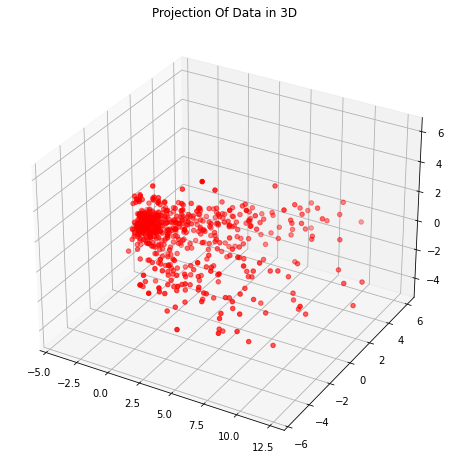

In [20]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(ftest_reduced["Dim1"],ftest_reduced["Dim2"],ftest_reduced["Dim3"], c="red", marker="o")
ax.set_title("Projection Of Data in 3D")
plt.show()

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


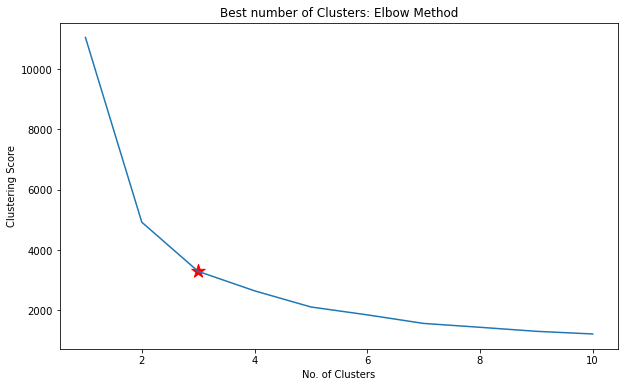

In [21]:
clustering_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 35)
    kmeans.fit(ftest_reduced)
    clustering_score.append(kmeans.inertia_) # inertia_ = Sum of squared distances of samples to their closest cluster center.
    

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), clustering_score)
# Added in after seeing the plot first, to indicate best number of clusters
plt.scatter(3,clustering_score[2], s = 200, c = 'red', marker='*') 
plt.title('Best number of Clusters: Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()

It seems like the best number of clusters is 3. But the ideal number and the realistic number are not always the same. Remember, we have a template from EA on how many clusters to use: 6. We shall do both.

##First, the suggested number of clusters.

In [21]:
ftest3 = ftest_reduced.copy()

AC = AgglomerativeClustering(n_clusters=3)
yhat3_AC = AC.fit_predict(ftest3)

ftest3["Clusters"] = yhat3_AC
ftest3.head(10)

,Dim1,Dim2,Dim3,Clusters
0,-3.138555,0.754756,-0.407639,2
1,-1.871727,-0.229389,-0.233885,2
2,-3.845591,0.711720,-0.616593,2
3,8.672692,0.549995,-2.237933,0
4,-3.927182,1.062723,-0.466604,2
5,-0.628191,0.379748,0.351281,1
6,-3.829318,1.081725,-0.480483,2
7,-3.824343,1.055801,-0.450875,2
8,1.714247,-1.581585,2.913467,1
9,-3.204634,0.159957,-0.688429,2


In [22]:
ftest6 = ftest_reduced.copy()

AC = AgglomerativeClustering(n_clusters=6)
yhat6_AC = AC.fit_predict(ftest6)

ftest6["Clusters"] = yhat6_AC
ftest6.head(10)

,Dim1,Dim2,Dim3,Clusters
0,-3.138555,0.754756,-0.407639,2
1,-1.871727,-0.229389,-0.233885,2
2,-3.845591,0.711720,-0.616593,2
3,8.672692,0.549995,-2.237933,3
4,-3.927182,1.062723,-0.466604,2
5,-0.628191,0.379748,0.351281,4
6,-3.829318,1.081725,-0.480483,2
7,-3.824343,1.055801,-0.450875,2
8,1.714247,-1.581585,2.913467,5
9,-3.204634,0.159957,-0.688429,2


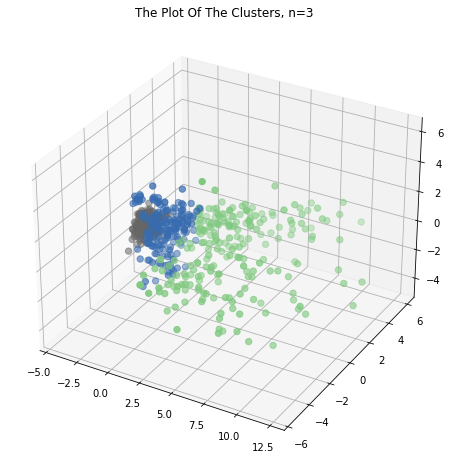

In [23]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(ftest3["Dim1"],ftest3["Dim2"],ftest3["Dim3"], s=40, c=ftest3["Clusters"], marker='o', cmap = "Accent")
ax.set_title("The Plot Of The Clusters, n=3")
plt.show()

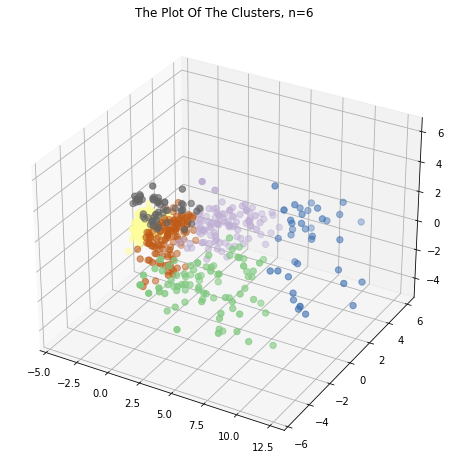

In [24]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(ftest6["Dim1"],ftest6["Dim2"],ftest6["Dim3"], s=40, c=ftest6["Clusters"], marker='o', cmap = "Accent")
ax.set_title("The Plot Of The Clusters, n=6")
plt.show()

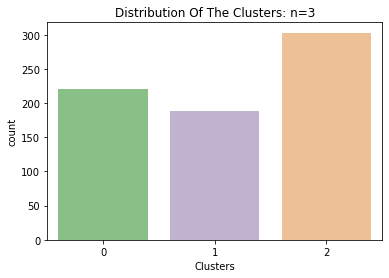

In [26]:
fig = sns.countplot(x=ftest3["Clusters"], palette= "Accent")
fig.set_title("Distribution Of The Clusters: n=3")
plt.show()

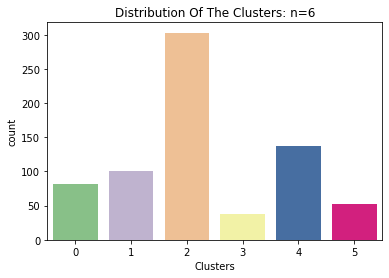

In [27]:
fig = sns.countplot(x=ftest6["Clusters"], palette= "Accent")
fig.set_title("Distribution Of The Clusters: n=6")
plt.show()

# Some conclusions
Both clustering algorithms seem to work just fine, with the n=3 clusters being a bit more even. On its face this seems that the n=3 is therefore better, but a bit of content knowledge might help us out here. In the NHL, it's not often theres an even distribution of all player types. This is especially true when we consider the enforcer player type, which is a dying bread in today's NHL. HAving one cluster that's mich smaller than the others is not unheard of.

To compare with the already known player types from EA, I will stick with the n=6 clusters.

In [25]:
# not to put the clusters back into our original dataframe
forward_df["Cluster"] = ftest6.loc[:,"Clusters"]
forward_df.head(10)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year,Cluster
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,...,12.5,92.0,10.22,3,7,2,5,28.6,2022,2
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,...,9.4,240.0,12.00,16,48,84,82,50.6,2022,2
2,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,...,0.0,7.0,7.00,0,4,1,2,33.3,2022,2
3,Sebastian Aho,24,CAR,F,79,37,44,81,18,38,...,16.7,1497.0,18.95,23,76,555,504,52.4,2022,3
4,Wade Allison,24,PHI,RW,1,0,0,0,-1,0,...,0.0,8.0,8.00,0,1,0,0,0.0,2022,2
5,Michael Amadio,25,VEG,C,53,11,7,18,0,15,...,17.7,653.0,12.32,16,39,30,40,42.9,2022,4
6,Michael Amadio,25,TOR,C,3,0,0,0,1,0,...,0.0,27.0,9.00,0,3,0,2,0.0,2022,2
7,Joey Anderson,23,TOR,RW,5,0,0,0,0,0,...,0.0,44.0,8.80,0,3,0,0,0.0,2022,2
8,Josh Anderson,27,MTL,RW,69,19,13,32,-25,65,...,12.6,1189.0,17.23,35,153,20,22,47.6,2022,5
9,Jaret Anderson-Dolan,22,LAK,C,7,0,0,0,-3,4,...,0.0,97.0,13.86,3,12,9,7,56.3,2022,2


In [33]:
forward_df.sort_values(by=['PTS'], ascending = False, inplace=True)
forward_df.head(35)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year,Cluster
434,Connor McDavid,25,EDM,C,80,44,79,123,28,45,...,14.0,1765.0,22.06,26,75,562,484,53.7,2022,3
287,Jonathan Huberdeau,28,FLA,LW,80,30,85,115,35,54,...,13.5,1554.0,19.42,28,99,18,36,33.3,2022,3
225,Johnny Gaudreau,28,CGY,LW,82,40,75,115,64,26,...,15.3,1523.0,18.57,9,10,1,0,100.0,2022,3
163,Leon Draisaitl,26,EDM,C,80,55,55,110,17,40,...,19.8,1788.0,22.35,25,53,887,774,53.4,2022,3
325,Kirill Kaprizov,24,MIN,LW,81,47,61,108,27,34,...,16.3,1548.0,19.11,29,73,5,4,55.6,2022,3
620,Steven Stamkos,31,TBL,C,81,42,64,106,24,36,...,17.4,1497.0,18.48,31,93,545,523,51.0,2022,3
426,Auston Matthews,24,TOR,C,73,60,46,106,20,18,...,17.2,1504.0,20.60,62,67,691,538,56.2,2022,3
662,Matthew Tkachuk,24,CGY,LW,82,42,62,104,57,68,...,16.6,1468.0,17.90,20,93,20,23,46.5,2022,3
450,J.T. Miller,28,VAN,C,80,32,67,99,15,47,...,15.5,1686.0,21.08,56,172,667,566,54.1,2022,3
420,Mitch Marner,24,TOR,RW,72,35,62,97,23,16,...,15.6,1504.0,20.89,31,75,10,8,55.6,2022,3


# Some Observations:

All the top like... 20 scorers? Are being put into the same cluster. This isn't that surprising, as the data we had was mostly scoring statistics. You WOULD put all the top scorers together. Even when we lowered the dimension with PCA, the underlying stats were still mostly scoring data, so the clusters are mostly scoring clusters. This can be fixed with additional data, like penalty killing time, advanced stats, etc. 
However, this excersize is just to show off the clustering method and for me to practice. We can simply redo this analysisin minutes by putting in a new URL or a new CSV at the start with better stats. I imagine this will happen again when we do the same process with the defencemen.

In [26]:
dtest = def_df.drop(['Player', 'Age', 'Tm', 'Pos', 'GP'], axis=1)
dtest.head()

,G,A,PTS,+/-,PIM,PS,EV,PP,SH,GW,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,2,2,4,-4,2,0.3,2,0,0,0,...,17,11.8,207.0,13.80,6,12,0,0,0.0,2022
1,1,0,1,-3,0,0.1,0,1,0,0,...,5,20.0,96.0,16.00,5,8,0,0,0.0,2022
2,2,10,12,-6,10,1.7,2,0,0,0,...,34,5.9,592.0,16.44,42,32,0,0,0.0,2022
3,0,0,0,0,2,0.0,0,0,0,0,...,0,0.0,11.0,11.00,0,1,0,0,0.0,2022
4,2,6,8,6,8,2.6,2,0,0,1,...,58,3.4,1147.0,20.12,69,133,0,0,0.0,2022


<AxesSubplot:>

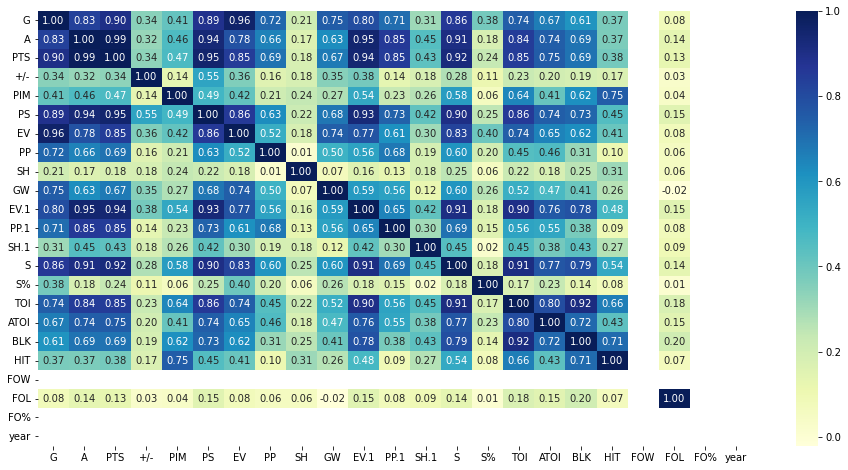

In [27]:
plt.figure(figsize= (16, 8))
sns.heatmap(dtest.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f')

In [28]:
dtest_scaled = dtest.copy()
scaler = StandardScaler()
scaler.fit(dtest_scaled)

dtest_scaled = pd.DataFrame(scaler.transform(dtest_scaled), columns=dtest_scaled.columns)
dtest_scaled.head()

,G,A,PTS,+/-,PIM,PS,EV,PP,SH,GW,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year
0,-0.290600,-0.734092,-0.652110,-0.360851,-0.898213,-0.785744,-0.207888,-0.358298,-0.22343,-0.497508,...,-0.790791,1.630666,-0.964869,-0.857132,-1.081242,-0.841828,0.0,-0.128212,0.0,0.0
1,-0.543089,-0.884519,-0.831408,-0.284914,-0.989964,-0.856072,-0.847941,0.447330,-0.22343,-0.497508,...,-0.994212,3.385774,-1.137582,-0.330438,-1.102081,-0.912091,0.0,-0.128212,0.0,0.0
2,-0.290600,-0.132384,-0.173982,-0.512723,-0.531212,-0.293445,-0.207888,-0.358298,-0.22343,-0.497508,...,-0.502612,0.367845,-0.365821,-0.225100,-0.331057,-0.490514,0.0,-0.128212,0.0,0.0
3,-0.795578,-0.884519,-0.891174,-0.057106,-0.898213,-0.891236,-0.847941,-0.358298,-0.22343,-0.497508,...,-1.078971,-0.894977,-1.269839,-1.527469,-1.206273,-1.035051,0.0,-0.128212,0.0,0.0
4,-0.290600,-0.433238,-0.413046,0.398512,-0.622962,0.023032,-0.207888,-0.358298,-0.22343,0.494833,...,-0.095770,-0.167249,0.497743,0.655915,0.231582,1.283623,0.0,-0.128212,0.0,0.0


In [29]:
pca = PCA(n_components=3)
pca.fit(dtest_scaled)
dtest_reduced = pd.DataFrame(pca.transform(dtest_scaled), columns=(["Dim1", "Dim2", "Dim3"]))
dtest_reduced.head()

,Dim1,Dim2,Dim3
0,-2.524005,1.170271,-0.928969
1,-2.644660,1.680004,-1.525055
2,-1.203813,0.458051,0.085119
3,-3.611049,0.771117,0.202245
4,-0.161501,-0.744156,-0.590560


In [30]:
dtest_reduced.describe().T

,count,mean,std,min,25%,50%,75%,max
Dim1,371.0,3.471317e-17,3.306165,-4.186411,-2.679942,-0.949179,2.056348,13.591159
Dim2,371.0,-1.436407e-17,1.403697,-5.828824,-0.755063,0.385993,0.729146,6.846021
Dim3,371.0,-2.214461e-17,1.098747,-4.920490,-0.535642,0.166962,0.459392,5.551617


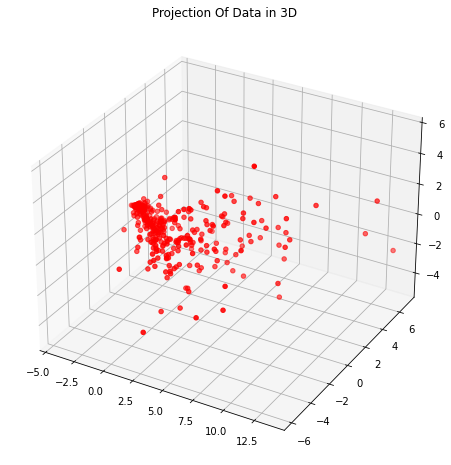

In [31]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(dtest_reduced["Dim1"],dtest_reduced["Dim2"],dtest_reduced["Dim3"], c="red", marker="o")
ax.set_title("Projection Of Data in 3D")
plt.show()

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


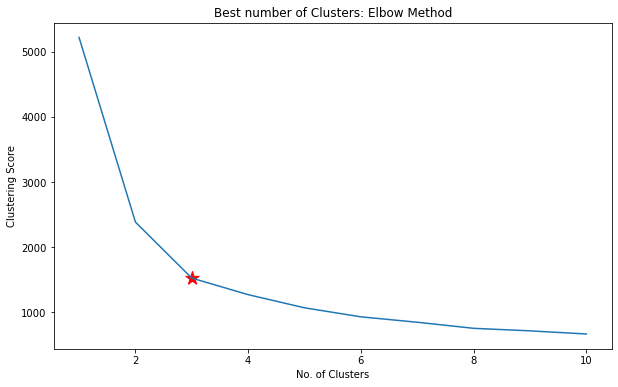

In [32]:
clustering_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 29)
    kmeans.fit(dtest_reduced)
    clustering_score.append(kmeans.inertia_) # inertia_ = Sum of squared distances of samples to their closest cluster center.
    

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), clustering_score)
# Added in after seeing the plot first, to indicate best number of clusters
plt.scatter(3,clustering_score[2], s = 200, c = 'red', marker='*') 
plt.title('Best number of Clusters: Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()

In [33]:
dtest3 = dtest_reduced.copy()

AC = AgglomerativeClustering(n_clusters=3)
yhat3_AC = AC.fit_predict(dtest3)

dtest3["Clusters"] = yhat3_AC
dtest3.head(10)

,Dim1,Dim2,Dim3,Clusters
0,-2.524005,1.170271,-0.928969,0
1,-2.644660,1.680004,-1.525055,0
2,-1.203813,0.458051,0.085119,0
3,-3.611049,0.771117,0.202245,0
4,-0.161501,-0.744156,-0.590560,0
5,5.517963,0.775410,1.398977,2
6,-2.137749,0.877872,-1.050119,0
7,-2.447700,0.488380,-0.200864,0
8,3.672395,1.890271,1.898844,1
9,-2.647809,1.000934,-0.357456,0


In [34]:
dtest4 = dtest_reduced.copy()

AC = AgglomerativeClustering(n_clusters=4)
yhat4_AC = AC.fit_predict(dtest4)

dtest4["Clusters"] = yhat4_AC
dtest4.head(10)

,Dim1,Dim2,Dim3,Clusters
0,-2.524005,1.170271,-0.928969,1
1,-2.644660,1.680004,-1.525055,1
2,-1.203813,0.458051,0.085119,3
3,-3.611049,0.771117,0.202245,1
4,-0.161501,-0.744156,-0.590560,3
5,5.517963,0.775410,1.398977,2
6,-2.137749,0.877872,-1.050119,1
7,-2.447700,0.488380,-0.200864,1
8,3.672395,1.890271,1.898844,0
9,-2.647809,1.000934,-0.357456,1


# Differences between Forwards and Defencemen
I chose 4 clusters to try because that's the number EA has chosen, but the "Ideal" choice is still 3 clusters. We still did both choices.

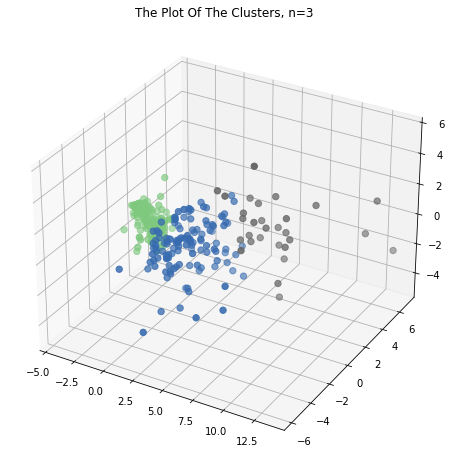

In [35]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(dtest3["Dim1"],dtest3["Dim2"],dtest3["Dim3"], s=40, c=dtest3["Clusters"], marker='o', cmap = "Accent")
ax.set_title("The Plot Of The Clusters, n=3")
plt.show()

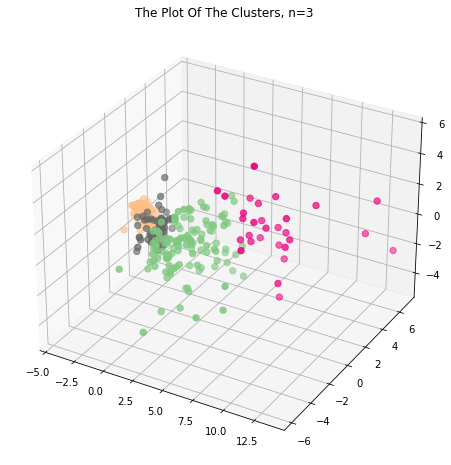

In [36]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(dtest4["Dim1"],dtest4["Dim2"],dtest4["Dim3"], s=40, c=dtest4["Clusters"], marker='o', cmap = "Accent")
ax.set_title("The Plot Of The Clusters, n=3")
plt.show()

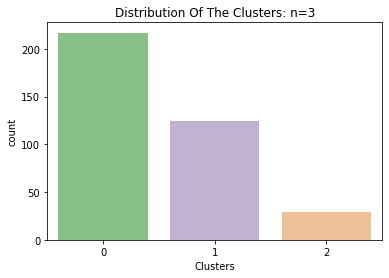

In [37]:
fig = sns.countplot(x=dtest3["Clusters"], palette= "Accent")
fig.set_title("Distribution Of The Clusters: n=3")
plt.show()

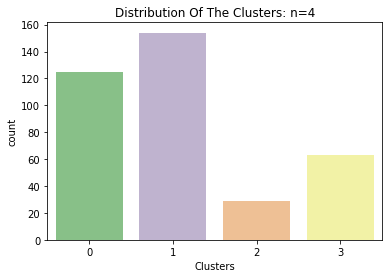

In [38]:
fig = sns.countplot(x=dtest4["Clusters"], palette= "Accent")
fig.set_title("Distribution Of The Clusters: n=4")
plt.show()

In [39]:
# not to put the clusters back into our original dataframe
def_df["Cluster"] = dtest4.loc[:,"Clusters"]
def_df.head(10)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year,Cluster
0,Calen Addison,21,MIN,D,15,2,2,4,-4,2,...,11.8,207.0,13.80,6,12,0,0,0.0,2022,1
1,Jack Ahcan,24,BOS,D,6,1,0,1,-3,0,...,20.0,96.0,16.00,5,8,0,0,0.0,2022,1
2,Sebastian Aho,25,NYI,D,36,2,10,12,-6,10,...,5.9,592.0,16.44,42,32,0,0,0.0,2022,3
3,Alexander Alexeyev,22,WSH,D,1,0,0,0,0,2,...,0.0,11.0,11.00,0,1,0,0,0.0,2022,1
4,Michael Anderson,22,LAK,D,57,2,6,8,6,8,...,3.4,1147.0,20.12,69,133,0,0,0.0,2022,3
5,Rasmus Andersson,25,CGY,D,82,4,46,50,30,28,...,2.6,1859.0,22.67,125,63,0,0,0.0,2022,2
6,Ronald Attard,22,PHI,D,15,2,2,4,-2,8,...,12.5,249.0,16.60,17,24,0,0,0.0,2022,1
7,Kevin Bahl,21,NJD,D,17,1,3,4,-6,10,...,6.3,268.0,15.76,15,28,0,0,0.0,2022,1
8,Tyson Barrie,30,EDM,D,73,7,34,41,3,18,...,4.7,1384.0,18.96,73,27,0,0,0.0,2022,0
9,Justin Barron,20,MTL,D,5,1,1,2,-2,0,...,7.7,95.0,19.00,4,4,0,0,0.0,2022,1


In [40]:
def_df.sort_values(by=['PTS'], ascending = False, inplace=True)
def_df.head(35)

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,year,Cluster
166,Roman Josi,31,NSH,D,80,23,73,96,13,46,...,8.2,2044.0,25.55,133,66,0,0,0.0,2022,2
216,Cale Makar,23,COL,D,77,28,58,86,48,26,...,11.7,1976.0,25.66,110,95,0,0,0.0,2022,2
143,Victor Hedman,31,TBL,D,82,20,65,85,26,36,...,9.1,2056.0,25.07,129,93,0,0,0.0,2022,2
108,Adam Fox,23,NYR,D,78,11,63,74,18,26,...,7.0,1865.0,23.91,128,30,0,0,0.0,2022,2
46,John Carlson,32,WSH,D,78,17,54,71,13,20,...,8.7,1857.0,23.81,112,73,0,0,0.0,2022,2
287,Morgan Rielly,27,TOR,D,82,10,58,68,16,40,...,4.5,1947.0,23.74,87,92,0,0,0.0,2022,2
151,Quinn Hughes,22,VAN,D,76,8,60,68,10,28,...,5.3,1919.0,25.25,56,19,0,0,0.0,2022,2
198,Kris Letang,34,PIT,D,78,10,58,68,20,49,...,4.7,2011.0,25.78,122,171,0,0,0.0,2022,2
93,Aaron Ekblad,25,FLA,D,61,15,42,57,38,26,...,8.3,1520.0,24.92,69,62,0,0,0.0,2022,2
344,Devon Toews,27,COL,D,66,13,44,57,52,20,...,8.2,1674.0,25.36,85,54,0,0,0.0,2022,2


# Additional Observations:
The defencemen fall into the same trap as the forwards. The statistics being weighed heavily towards scoring statistics makes it hard not to. However, this isn't as big a deal for defencemen, since there is a playstyle specifically for this: Offensive Defenceman. 

# Fitting a model

Now I want to create a model that will determine which cluster players should fall into. I chose Random Forrest classifier because I saw it being used a lot, I enjoy the naming convention of a lot of trees making a forest, and from the looks of it the process is extremely similar regardless of what model you choose. 

Let's create a random forrest classifier, fit it to the data, and see if it can fit the data nicely. The defencemen dataframe isn't incredibly large, so the numbers may not be wonderful for that one, looking forward to the future.

In [57]:
kmeansdf = forward_df.copy()
kmeansdf = kmeansdf.drop(['Player', 'Tm', 'Pos'], axis=1)

# Let's remove the cluster column from our dataframe, because that's the thing we want to predict.
X = kmeansdf.iloc[:, :-1].values
y = kmeansdf.iloc[:, -1].values

# And now to split into train and test sets. Luckily, there's already a built in function to do precisely that! 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [58]:
# Let's bring in random forest stuff.
from sklearn.ensemble import RandomForestClassifier

#Picking random states and estimators.
rf= RandomForestClassifier(n_estimators=100,random_state=2)
rf.fit(X_train,y_train)

print("random forest score :",rf.score(X_test,y_test))

random forest score : 0.9230769230769231


## The score for this classifier is actually pretty good!

At 92%, we can call this a success. I still have issues with the clusters themselves, as previously discussed. But if we ignore that, than the model actually does quite well!

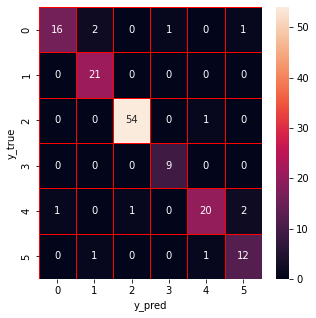

In [59]:
# Let's see how the model did on an individual choice level. We do that by making a confusion matrix.

cm=confusion_matrix(y_test,rf.predict(X_test))

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [62]:
# Just checking if the accuracy_score() is the same as rf.score(). It appears it is.
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9230769230769231

## Looking at the confusion matrix

We can see most predictions matched up with the solution set. In fact, ALL the players that fell into cluster 3 were predicted correctly! Neat!

## Now let's do the exact same thing to the defencemen

In [53]:
kmeansdf = def_df.copy()
kmeansdf = kmeansdf.drop(['Player', 'Tm', 'Pos'], axis=1)
X = kmeansdf.iloc[:, :-1].values
y = kmeansdf.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [54]:
rf= RandomForestClassifier(n_estimators=100,random_state=2)
rf.fit(X_train,y_train)
print("random forest score :",rf.score(X_test,y_test))

random forest score : 0.92


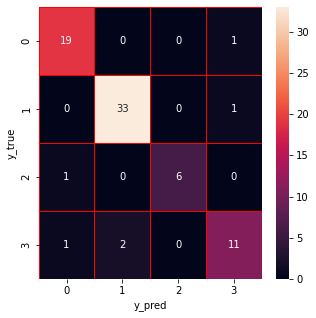

In [55]:
cm=confusion_matrix(y_test,rf.predict(X_test))

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()